In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


In [25]:
print("Fetching weather data...")
url = (
    "https://www.ncei.noaa.gov/access/services/data/v1?"
    "dataset=daily-summaries&dataTypes=TAVG,TMAX,TMIN,PRCP"
    "&stations=IN009010100&startDate=1901-01-01&endDate=2024-04-15"
    "&includeStationName=true&includeStationLocation=1&units=metric"
)

Fetching weather data...


In [26]:
df = pd.read_csv(url, parse_dates=['DATE'], index_col='DATE', na_values=['NaN'])
print("Initial shape:", df.shape)
df.head()

Initial shape: (43275, 9)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,,,
1901-01-01,IN009010100,"BANGALORE, IN",12.967,77.583,921.0,0.0,NaN,NaN,NaN
1901-01-02,IN009010100,"BANGALORE, IN",12.967,77.583,921.0,0.0,NaN,NaN,NaN
1901-01-03,IN009010100,"BANGALORE, IN",12.967,77.583,921.0,0.0,NaN,NaN,NaN
1901-01-04,IN009010100,"BANGALORE, IN",12.967,77.583,921.0,0.0,NaN,NaN,NaN
1901-01-05,IN009010100,"BANGALORE, IN",12.967,77.583,921.0,0.0,NaN,NaN,NaN


In [27]:
# Preprocess Data
# Interpolate missing values
df = df.interpolate(method='time').ffill().bfill()

# Use selected columns
data = df[['TAVG', 'TMAX', 'TMIN', 'PRCP']].copy()

# Fill missing TAVG using (TMAX + TMIN) / 2
mask = data['TAVG'].isna()
data.loc[mask, 'TAVG'] = (data.loc[mask, 'TMAX'] + data.loc[mask, 'TMIN']) / 2

# Drop any remaining missing values
data = data.dropna()



/tmp/ipython-input-1586906383.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time').ffill().bfill()


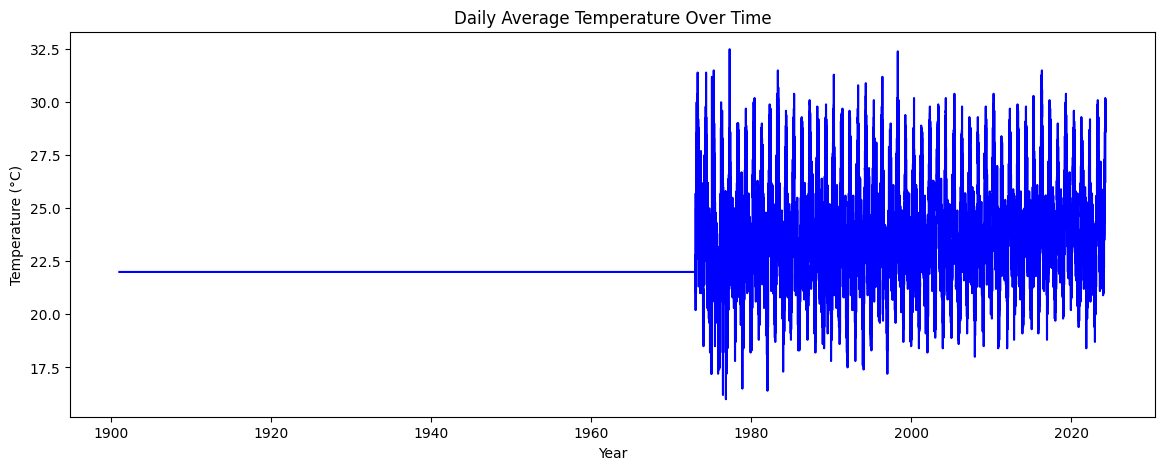

In [28]:
plt.figure(figsize=(14,5))
plt.plot(df['TAVG'], color='blue')
plt.title("Daily Average Temperature Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()


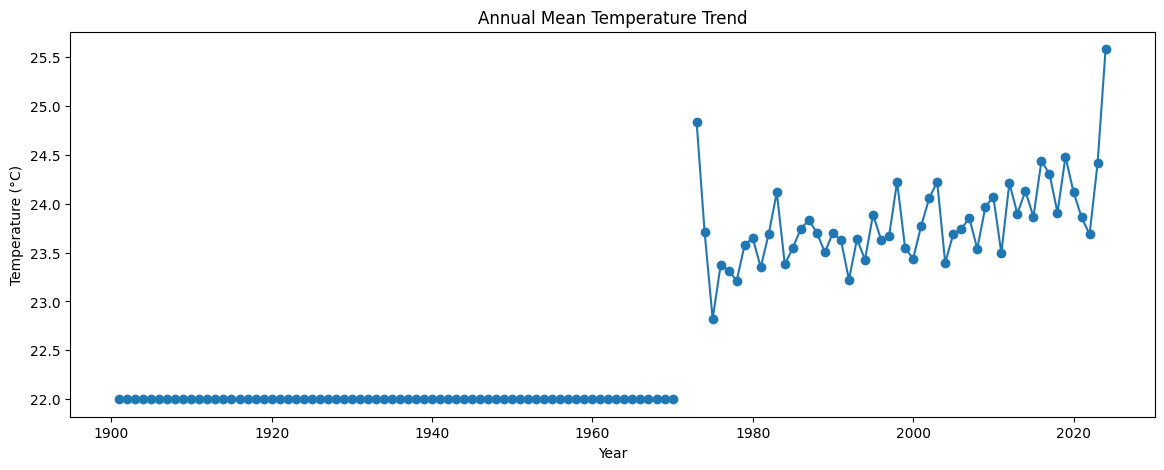

In [29]:
annual_mean = df['TAVG'].resample('YE').mean()

plt.figure(figsize=(14,5))
plt.plot(annual_mean.index.year, annual_mean.values, marker='o')
plt.title("Annual Mean Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()


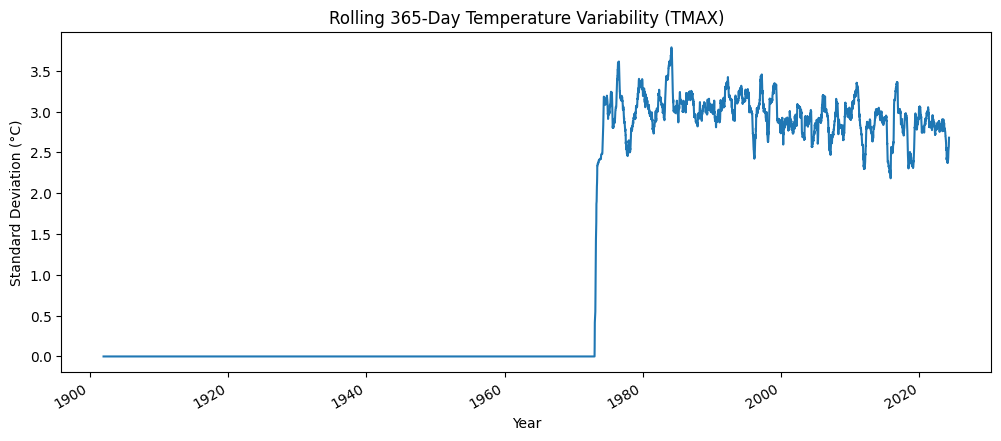

In [30]:
# Rolling 365-day variability in daily maximum temperature
df["rolling_std_TMAX"] = df["TMAX"].rolling(365).std()

plt.figure(figsize=(12,5))
df["rolling_std_TMAX"].plot()
plt.title("Rolling 365-Day Temperature Variability (TMAX)")
plt.ylabel("Standard Deviation (°C)")
plt.xlabel("Year")
plt.show()


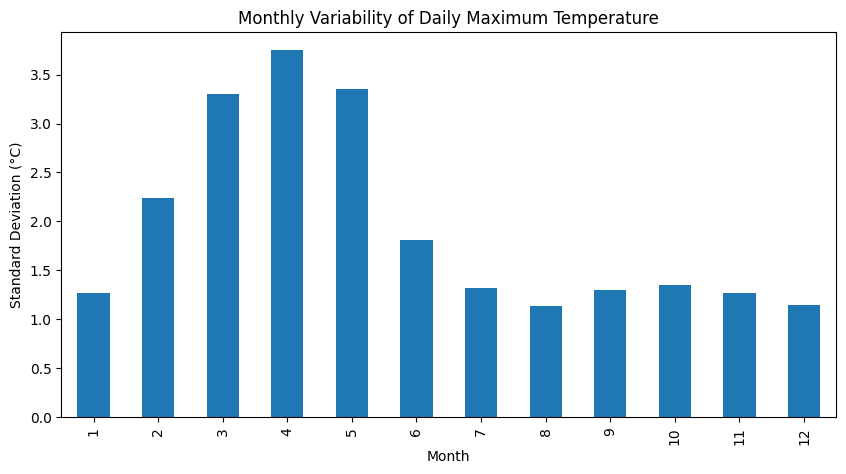

In [31]:
# Monthly variability (climatological)
monthly_variability = df["TMAX"].groupby(df.index.month).std()

plt.figure(figsize=(10,5))
monthly_variability.plot(kind="bar")
plt.title("Monthly Variability of Daily Maximum Temperature")
plt.xlabel("Month")
plt.ylabel("Standard Deviation (°C)")
plt.show()


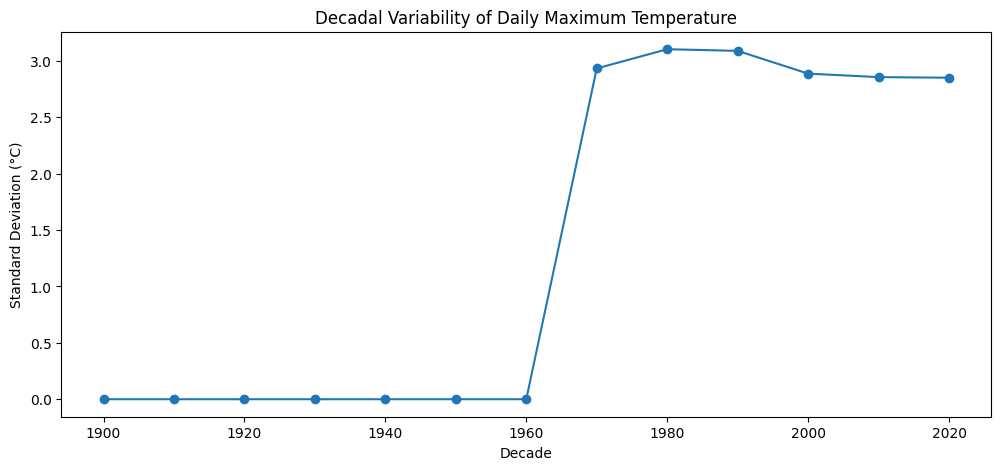

In [32]:
# Decadal temperature variability
df["decade"] = (df.index.year // 10) * 10
decadal_variability = df.groupby("decade")["TMAX"].std()

plt.figure(figsize=(12,5))
decadal_variability.plot(marker="o")
plt.title("Decadal Variability of Daily Maximum Temperature")
plt.xlabel("Decade")
plt.ylabel("Standard Deviation (°C)")
plt.show()


In [33]:
def extreme_days(df, threshold):
    """
    Count extreme temperature days per year.
    threshold: value above which a day is considered extreme.
    """
    extreme_mask = df['TMAX'] > threshold
    counts = extreme_mask.resample('YE').sum()
    return counts

# ===============================
# Test for extreme_days() function
# ===============================

test_df = pd.DataFrame(
    {"TMAX": [10, 20, 30, 5]},
    index=pd.to_datetime(["2000-01-01","2000-01-02","2000-01-03","2000-01-04"])
)

# Threshold = 25 → only the value 30 should count
result = extreme_days(test_df, threshold=25)

print("Extreme day count returned:", int(result.iloc[0]))

# Assertion to ensure correctness
assert int(result.iloc[0]) == 1, "extreme_days() failed the test!"

print("✔ TEST PASSED: extreme_days() works correctly.")


Extreme day count returned: 1
✔ TEST PASSED: extreme_days() works correctly.


In [34]:
# Sensitivity analysis for multiple thresholds
thresholds = {
    "mean + 1σ": df["TMAX"].mean() + 1*df["TMAX"].std(),
    "mean + 2σ": df["TMAX"].mean() + 2*df["TMAX"].std(),
    "mean + 3σ": df["TMAX"].mean() + 3*df["TMAX"].std(),
}

sensitivity_results = {}

for name, th in thresholds.items():
    series = extreme_days(df, th)
    slope, intercept, r, p, se = linregress(series.index.year, series.values)
    sensitivity_results[name] = {
        "threshold": th,
        "mean_extreme_days": series.mean(),
        "trend_per_year": slope,
        "p_value": p
    }

pd.DataFrame(sensitivity_results).T


,threshold,mean_extreme_days,trend_per_year,p_value
mean + 1σ,30.532986,50.750000,1.491081,2.641719e-38
mean + 2σ,32.909921,27.572581,0.793621,1.440730e-33
mean + 3σ,35.286856,6.588710,0.206858,3.637456e-17


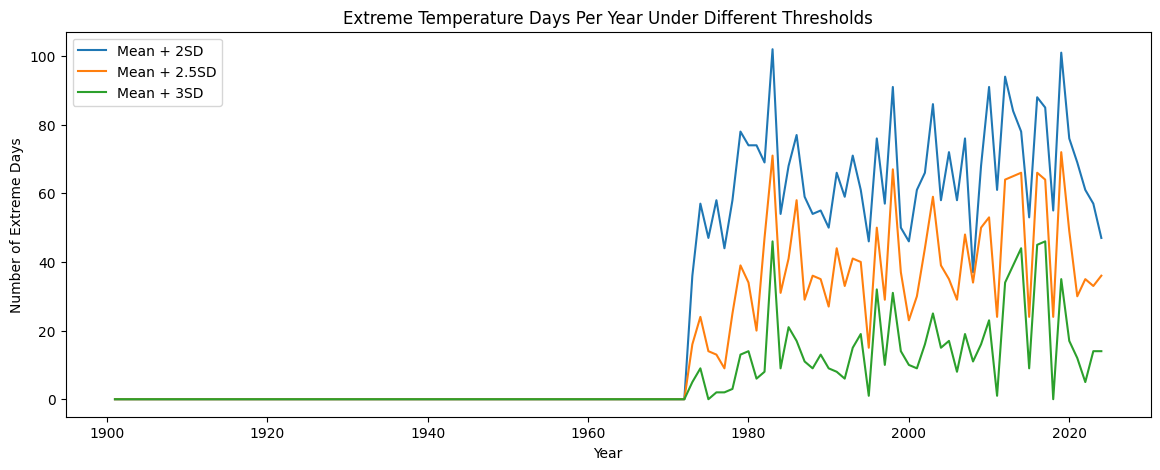

In [35]:
mean = df['TMAX'].mean()
std = df['TMAX'].std()

thresholds = {
    "Mean + 2SD": mean + 2*std,
    "Mean + 2.5SD": mean + 2.5*std,
    "Mean + 3SD": mean + 3*std
}

plt.figure(figsize=(14,5))

for label, th in thresholds.items():
    counts = extreme_days(df, th)
    plt.plot(counts.index.year, counts.values, label=label)

plt.title("Extreme Temperature Days Per Year Under Different Thresholds")
plt.xlabel("Year")
plt.ylabel("Number of Extreme Days")
plt.legend()
plt.show()


In [36]:
slope, intercept, r, p, se = linregress(annual_mean.index.year, annual_mean.values)

print("Slope:", slope)
print("p-value:", p)
print("R²:", r**2)


Slope: nan
p-value: nan
R²: nan


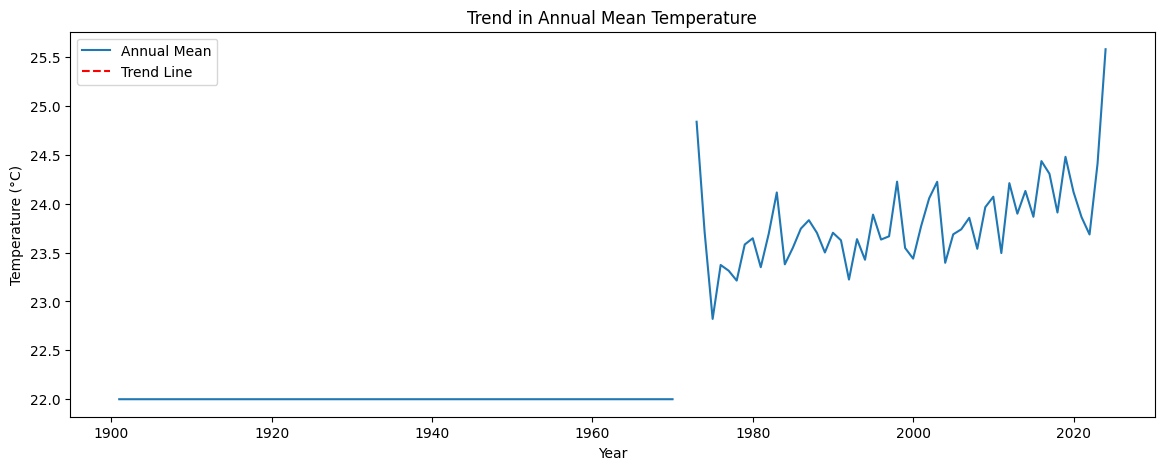

In [37]:
plt.figure(figsize=(14,5))
years = annual_mean.index.year
plt.plot(years, annual_mean.values, label="Annual Mean")
plt.plot(years, intercept + slope*years, 'r--', label="Trend Line")
plt.title("Trend in Annual Mean Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


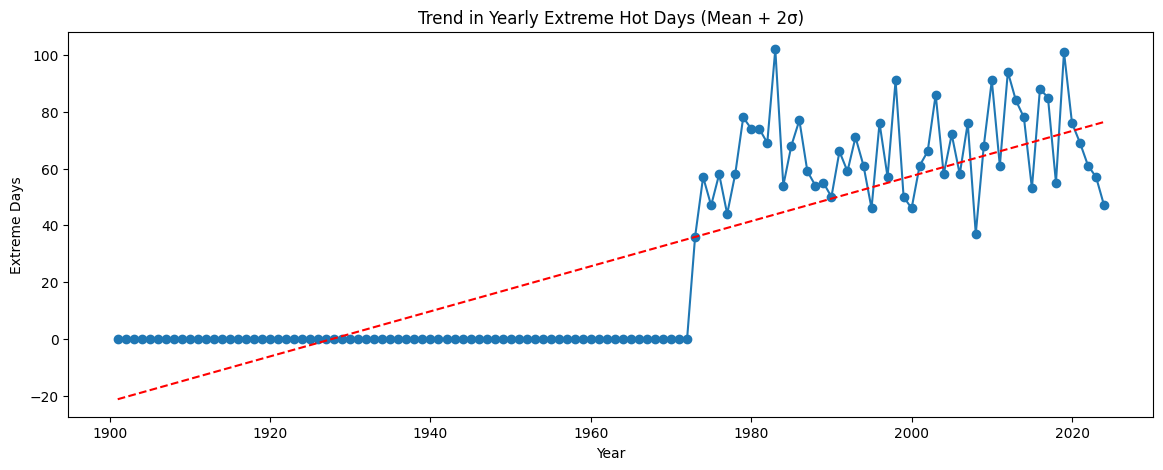

Slope: 0.79362077104642
p-value: 1.4407297296677864e-33
R²: 0.6986386954972091


In [38]:
extreme_main = extreme_days(df, mean + 2*std)

slope2, int2, r2, p2, se2 = linregress(extreme_main.index.year, extreme_main.values)

plt.figure(figsize=(14,5))
years = extreme_main.index.year
plt.plot(years, extreme_main.values, marker='o')
plt.plot(years, int2 + slope2*years, 'r--')
plt.title("Trend in Yearly Extreme Hot Days (Mean + 2σ)")
plt.xlabel("Year")
plt.ylabel("Extreme Days")
plt.show()

print("Slope:", slope2)
print("p-value:", p2)
print("R²:", r2**2)


In [39]:
summary = pd.DataFrame({
    "Threshold": list(thresholds.keys()),
    "Value": list(thresholds.values())
})

summary


,Threshold,Value
0,Mean + 2SD,32.909921
1,Mean + 2.5SD,34.098388
2,Mean + 3SD,35.286856


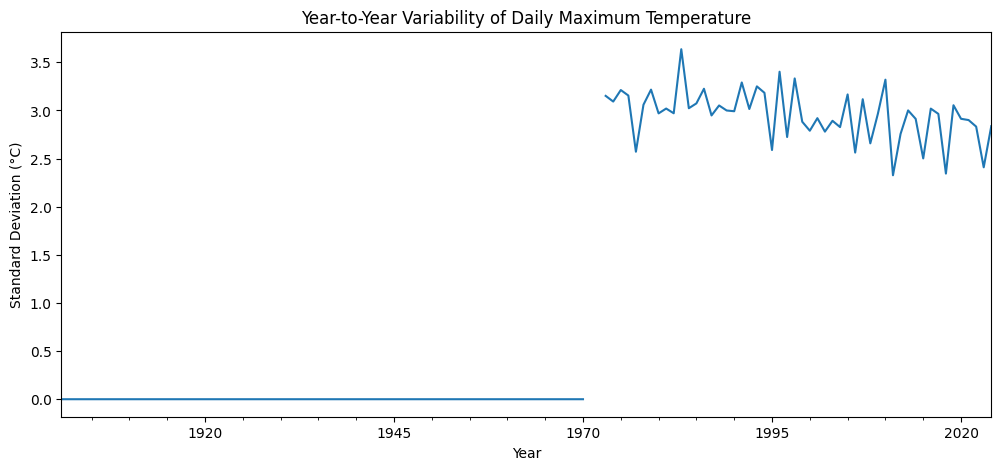

In [40]:
# Year-to-year variability of TMAX
yearly_std = df["TMAX"].resample("YE").std()

plt.figure(figsize=(12,5))
yearly_std.plot()
plt.title("Year-to-Year Variability of Daily Maximum Temperature")
plt.ylabel("Standard Deviation (°C)")
plt.xlabel("Year")
plt.show()
